In [1]:
import pandas as pd
import numpy as np
url = 'https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv'
data = pd.read_csv(url)
data.head(10)

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500
5,0,3,Mr. James Moran,male,27.0,0,0,8.4583
6,0,1,Mr. Timothy J McCarthy,male,54.0,0,0,51.8625
7,0,3,Master. Gosta Leonard Palsson,male,2.0,3,1,21.0750
8,1,3,Mrs. Oscar W (Elisabeth Vilhelmina Berg) Johnson,female,27.0,0,2,11.1333
9,1,2,Mrs. Nicholas (Adele Achem) Nasser,female,14.0,1,0,30.0708


In [2]:

import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# setup method for missing data using a median imputer for age and fair
numeric_features = ['Age', 'Fare', 'Siblings/Spouses Aboard', 'Parents/Children Aboard']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
     ('scaler', StandardScaler())])
# setup one hot enoding for catagorical features
categorical_features = [ 'Sex', 'Pclass']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# combine numeric and catagorical transformation into one column transformer object
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
pipe = Pipeline(steps=[('preprocessor', preprocessor)])

# drop rows where survived is unknown
y = data['Survived']
X = pipe.fit_transform(data)

# normalizes the feature names
feature_names = numeric_features +  pipe.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names().tolist()
feature_names = list(map(lambda x: x.replace('x0',categorical_features[0]), feature_names))
feature_names = list(map(lambda x: x.replace('x1',categorical_features[1]), feature_names))

In [3]:
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
n = 5
model = KNeighborsClassifier(n)
model.fit(X,y)

distances, indices = model.kneighbors(X[0:1,:])
distances, indices


(array([[0.        , 0.01004945, 0.14235178, 0.21281748, 0.21281748,
         0.21811669, 0.22741939, 0.28366769, 0.28381274, 0.30023713]]),
 array([[  0, 213, 661, 439, 265,  45, 739, 701, 369, 351]]))

In [4]:
def find_my_lookalike(name):
    temp_data =data.loc[data['Name'] == name]
    temp_data_transformed = pipe.transform(temp_data)
    distances, indices = model.kneighbors(temp_data_transformed)
    names = data['Name'].values
    survived = data['Survived'].values
    output = pd.DataFrame({'Name': names[indices.flatten()], 
                           'Dist': distances.flatten(),
                          'survived': survived[indices.flatten()]})
    return output.iloc[1:, :]
    
name = 'Mr. William Henry Allen'
find_my_lookalike(name)

,Name,Dist,survived
1,Mr. William Alfred Brocklebank,0.000000,0
2,Mr. Marin Markoff,0.003099,0
3,Mr. Sarkis Lahoud,0.016582,0
4,Mr. Matti Rintamaki,0.018591,0
5,Mr. Adola Asim,0.020099,0
6,Mr. Peter L Lemberopolous,0.048014,0
7,Mr. Simon Maisner,0.070852,0
8,Mr. Thomas Leonard Theobald,0.070852,0
9,Mr. William Morley,0.070852,0


In [61]:
data.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'Siblings/Spouses Aboard',
       'Parents/Children Aboard', 'Fare'],
      dtype='object')

In [62]:
import networkx as nx

def build_graph(names):
    G = nx.Graph()
    for name in names:
        look_alikes = find_my_lookalike(name)
        new_names = look_alikes['Name'].values
        new_weights = look_alikes['Dist'].values
        survived = data.loc[data['Name'] == name]['Survived'].values[0]
        for i, j in enumerate(new_names):
            G.add_edge(name, j, weight =new_weights[i])
    return G
def get_color(name):
    x = data.loc[data['Name'] == name]['Survived'].values[0]
    if x == 1:
        return 'blue'
    else:
        return 'red'

G = build_graph(data['Name'].values[1:20])
colors = list(map(get_color, G.nodes))

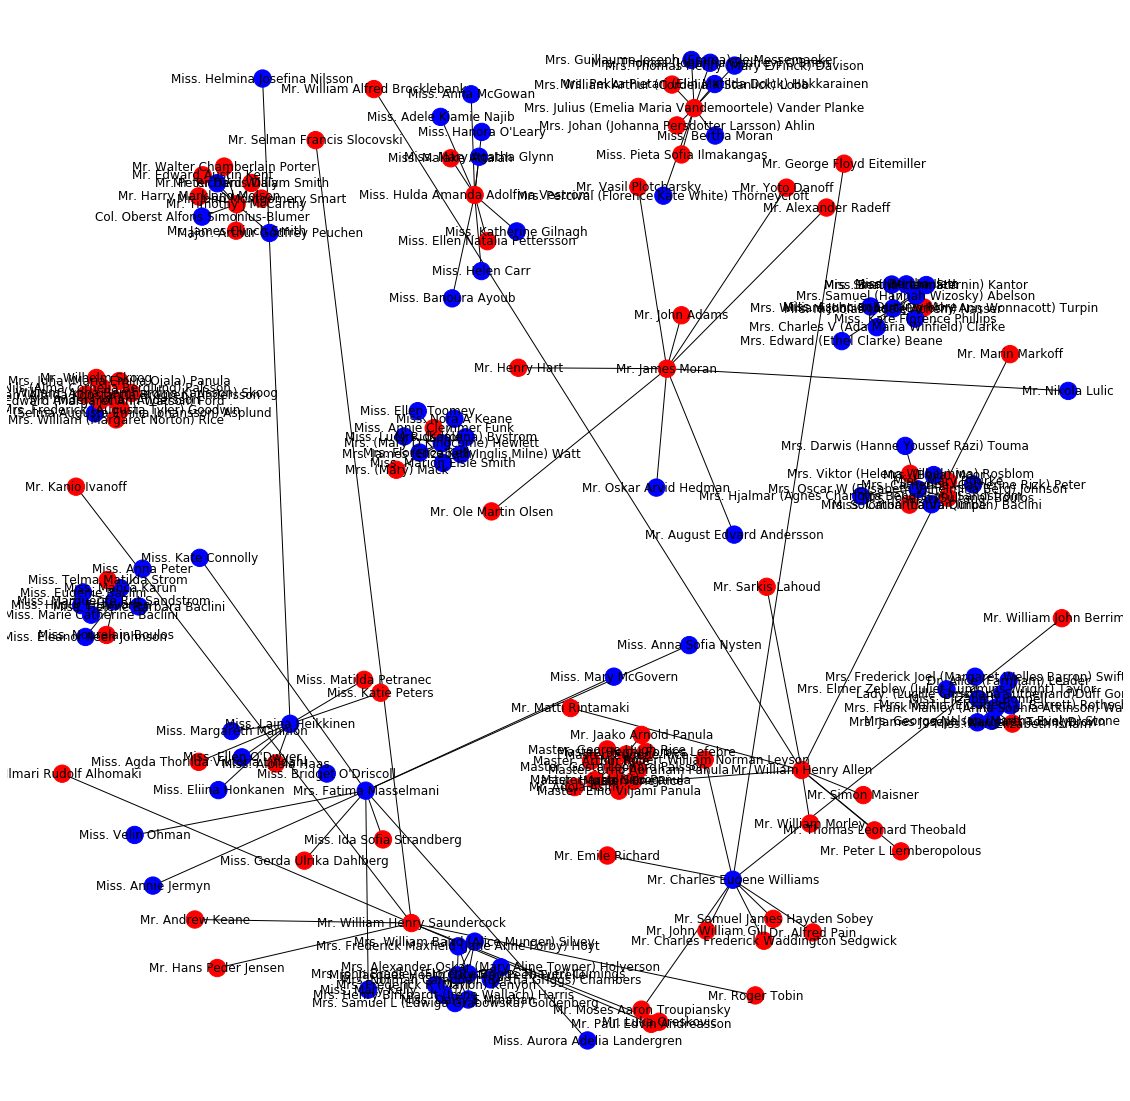

In [67]:
import matplotlib.pyplot as plt
plt.subplots(figsize=(20, 20))
nx.draw(G, with_labels=True, node_color=colors)
plt.show()